# Building an SVM from Scratch - Lab

## Introduction

In this lab, you'll program a simple Support Vector Machine from scratch!

## Objectives

In this lab you will: 

- Build a simple linear max margin classifier from scratch 
- Build a simple soft margin classifier from scratch

## The data

Support Vector Machines can be used for any $n$-dimensional feature space. However, for this lab, you'll focus on a more limited 2-dimensional feature space so that you can easily visualize the results.

Scikit-learn has an excellent set of dataset generator functions. One of them is `make_blobs()`. Below, you can find the code to create two blobs using the `make_blobs()` function. Afterward, you'll use this data to build your own SVM from scratch! 

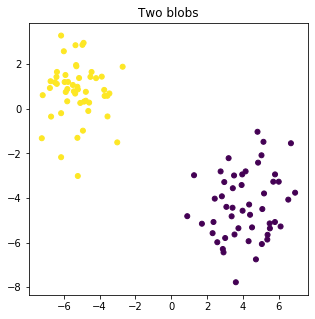

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

plt.figure(figsize=(5, 5))

plt.title('Two blobs')
X, labels = make_blobs(n_features=2, centers=2, cluster_std=1.25,  random_state=123)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=25);

In [2]:
!pip install cvxpy

     |████████████████████████████████| 1.3 MB 1.7 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.5 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 44 kB/s  eta 0:00:01
     |████████████████████████████████| 163 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 4.0 MB/s eta 0:00:01
  ERROR: Command errored out with exit status 1:
   command: /opt/anaconda3/envs/learn-env/bin/python3.6 /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pip/_vendor/pep517/_in_process.py build_wheel /var/folders/2q/71g07jvs3kj92z2fzw_1glp40000gn/T/tmpnwjciqjp
       cwd: /private/var/folders/2q/71g07jvs3kj92z2fzw_1glp40000gn/T/pip-install-rs51fvvu/cvxpy
  Complete output (424 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.7-x86_64-3.6
  creating build/lib.

  ERROR: Command errored out with exit status 1:
   command: /opt/anaconda3/envs/learn-env/bin/python3.6 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/2q/71g07jvs3kj92z2fzw_1glp40000gn/T/pip-install-rs51fvvu/scs/setup.py'"'"'; __file__='"'"'/private/var/folders/2q/71g07jvs3kj92z2fzw_1glp40000gn/T/pip-install-rs51fvvu/scs/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/2q/71g07jvs3kj92z2fzw_1glp40000gn/T/pip-wheel-ywf76iq9
       cwd: /private/var/folders/2q/71g07jvs3kj92z2fzw_1glp40000gn/T/pip-install-rs51fvvu/scs/
  Complete output (59 lines):
  Namespace(blas64=False, extraverbose=False, float32=False, gpu=False, int32=False, scs=False)
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.7-x86_64-3.6
  creating build/lib.macosx-10.7-x86_

Failed to build cvxpy scs
ERROR: Could not build wheels for cvxpy which use PEP 517 and cannot be installed directly


## Build a Max Margin classifier

Since you are aiming to maximize the margin between the decision boundary and the support vectors, creating a support vector machine boils down to solving a convex optimization problem. As such, you can use the Python library `cvxpy` to do so. More information can be found [here](http://www.cvxpy.org/).

You may have not used `cvxpy` before, so make sure it is installed on your local computer using `pip install cvxpy`.

The four important commands to be used here are:

- `cp.Variable()` where you either don't include anything between `()` or, if the variable is an array with multiple elements, the number of elements.
- `cp.Minimize()` or `cp.Maximize()`, with the element to be maximized passed in as a paramater.
- `cp.Problem(objective, constraints)`, the objective is generally a stored minimization or maximization objective, and the constraints are listed constraints. Constraints can be added by a "+" sign. 
- Next, you should store your `cp.Problem` in an object and use `object.solve()` to solve the optimization problem.

Recall that we're trying to solve this problem:

$ w x^{(i)} + b \geq 1$  if $y ^{(i)} = 1$

$ w x^{(i)} + b \leq -1$  if $y ^{(i)} = -1$

And, the objective function you're maximizing is $\dfrac{2}{\lVert w \rVert}$. To make things easier, you can instead minimize $\lVert w \rVert$

Note that $y^{(i)}$ is the class label. Take a look at the labels by printing them below.

In [3]:
# Print labels
labels

array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0])

Before you start to write down the optimization problem, split the data in the two classes. Name them `class_1` and `class_2`.

In [4]:
# Assign label 0 to class_1
class_1 = X[labels == 0]

# Assign label 1 to class_2
class_2 = X[labels == 1]

Next, you need to find a way to create a hyperplane (in this case, a line) that can maximize the difference between the two classes. 
Here's a pseudocode outline:
- First, `import cvxpy as cp`
- Next, define the variables. note that `b` and `w` are variables (What are the dimensions?)
- Then, build the constraints (You have two constraints here)
- After that, use "+" to group the constraints together
- The next step is to define the objective function
- After that, define the problem using `cp.Problem()`
- Solve the problem using `.solve()`
- Finally, print the problem status (however you defined the problem, and attach `.status`) 

In [5]:
import cvxpy as cp

d = 2  
m = 50 
n = 50  

# Define the variables
w = cp.Variable(d)
b = cp.Variable()

# Define the constraints
x_constraints = [w.T * class_1[i] + b >= 1  for i in range(m)]
y_constraints = [w.T * class_2[i] + b <= -1 for i in range(n)]

# Sum the constraints
constraints = x_constraints +  y_constraints 

# Define the objective. Hint: use cp.norm
obj = cp.Minimize(cp.norm(w, 2))

# Add objective and constraint in the problem
prob = cp.Problem(obj, constraints)

# Solve the problem
prob.solve()
print('Problem Status: %s'%prob.status)

ModuleNotFoundError: No module named 'cvxpy'

Great! Below is a helper function to assist you in plotting the result of your SVM classifier.

In [ ]:
## A helper function for plotting the results, the decision plane, and the supporting planes

def plotBoundaries(x, y, w, b):
    # Takes in a set of datapoints x and y for two clusters,
    d1_min = np.min([x[:,0], y[:,0]])
    d1_max = np.max([x[:,0], y[:,0]])
    # Line form: (-a[0] * x - b ) / a[1]
    d2_at_mind1 = (-w[0]*d1_min - b ) / w[1]
    d2_at_maxd1 = (-w[0]*d1_max - b ) / w[1]
    sup_up_at_mind1 = (-w[0]*d1_min - b + 1 ) / w[1]
    sup_up_at_maxd1 = (-w[0]*d1_max - b + 1 ) / w[1]
    sup_dn_at_mind1 = (-w[0]*d1_min - b - 1 ) / w[1]
    sup_dn_at_maxd1 = (-w[0]*d1_max - b - 1 ) / w[1]

    # Plot the clusters!
    plt.scatter(x[:,0], x[:,1], color='purple')
    plt.scatter(y[:,0], y[:,1], color='yellow')
    plt.plot([d1_min,d1_max], [d2_at_mind1, d2_at_maxd1], color='black')
    plt.plot([d1_min,d1_max], [sup_up_at_mind1, sup_up_at_maxd1],'-.', color='blue')
    plt.plot([d1_min,d1_max], [sup_dn_at_mind1, sup_dn_at_maxd1],'-.', color='blue')
    plt.ylim([np.floor(np.min([x[:,1],y[:,1]])), np.ceil(np.max([x[:,1], y[:,1]]))])

Use the helper function to plot your result. To get the values of `w` and `b`, use the `.value` attribute. 

In [ ]:
w = w.value
b = b.value

In [ ]:
# Plot 
plotBoundaries(class_1, class_2, w, b)

## A more complex problem

Now, take a look at another problem by running the code below. This example will be a little trickier as the two classes are not perfectly linearly separable.

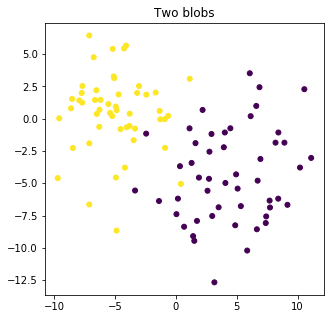

In [6]:
plt.figure(figsize=(5, 5))

plt.title('Two blobs')
X, labels = make_blobs(n_features=2, centers=2, cluster_std=3,  random_state=123)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=25);

Copy your optimization code from the Max Margin Classifier and look at the problem status. What do you see?

In [ ]:
# Copy the optimization code from above 

class_1 = X[labels == 0]
class_2 = X[labels == 1]

d = 2  
m = 50 
n = 50  

# Define the variables
w = cp.Variable(d)
b = cp.Variable()

# Define the constraints
x_constraints = [w.T * class_1[i] + b >= 1  for i in range(m)]
y_constraints = [w.T * class_2[i] + b <= -1 for i in range(n)]

# Sum the constraints
constraints = x_constraints +  y_constraints 

# Define the objective. Hint: use cp.norm
obj = cp.Minimize(cp.norm(w,2))

# Add objective and constraint in the problem
prob = cp.Problem(obj, constraints)

# Solve the problem
prob.solve()
print('Problem Status: %s'%prob.status)

# Problem Status: infeasible

### What's happening?

The problem status is "infeasible". In other words, the problem is not linearly separable, and it is impossible to draw one straight line that separates the two classes.

## Build a Soft Margin classifier

To solve this problem, you'll need to "relax" your constraints and allow for items that are not correctly classified. This is where the Soft Margin classifier comes in! As a refresher, this is the formulation for the Soft Margin classifier:

$$ b + w_Tx^{(i)} \geq 1-\xi^{(i)}  \text{     if     } y ^{(i)} = 1$$

$$ b + w_Tx^{(i)} \leq -1+\xi^{(i)}  \text{     if     } y ^{(i)} = -1$$


The objective function is 

 $$\dfrac{1}{2}\lVert w \rVert^2+ C(\sum_i \xi^{(i)})$$
 
Use the code for the SVM optimization again, but adjust for the slack parameters $\xi$ (ksi or xi).
 
Some important things to note:
- Every $\xi$ needs to be positive, that should be added as constraints
- Your objective needs to be changed as well
- Allow for a "hyperparameter" $C$ which you set to 1 at first and you can change accordingly. Describe how your result changes 


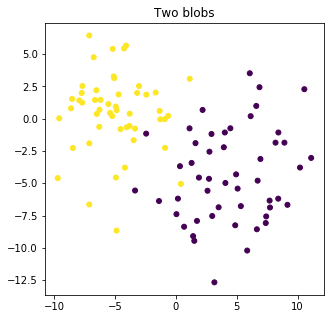

In [7]:
plt.figure(figsize=(5, 5))

plt.title('Two blobs')
X, labels = make_blobs(n_features=2, centers=2, cluster_std=3,  random_state=123)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=25);

In [ ]:
# Reassign the class labels
class_1 = X[labels == 0]
class_2 = X[labels == 1]

In [ ]:
d = 2  
m = 50 
n = 50  

# Define the variables
w = cp.Variable(d)
b = cp.Variable()
ksi_1 = cp.Variable(m)
ksi_2 = cp.Variable(n)

C=0.01

# Define the constraints
x_constraints = [w.T * class_1[i] + b >= 1 - ksi_1[i]  for i in range(m)]
y_constraints = [w.T * class_2[i] + b <= -1 + ksi_2[i] for i in range(n)]
ksi_1_constraints = [ksi_1 >= 0  for i in range(m)]
ksi_2_constraints = [ksi_2 >= 0  for i in range(n)]

# Sum the constraints
constraints = x_constraints +  y_constraints + ksi_1_constraints + ksi_2_constraints

# Define the objective. Hint: use cp.norm. Add in a C hyperparameter and assume 1 at first
obj = cp.Minimize(cp.norm(w,2) + C * (sum(ksi_1) + sum(ksi_2)))

# Add objective and constraint in the problem
prob = cp.Problem(obj, constraints)

# Solve the problem
prob.solve()
print('Problem Status: %s'%prob.status)

Plot your result again.

In [ ]:
# Your code here
w = w.value
b = b.value
plotBoundaries(class_1, class_2, w, b)

Now go ahead and experiment with the hyperparameter $C$ (making it both larger and smaller than 1). What do you see?

## Summary

Great! You now understand the rationale behind support vector machines. Wouldn't it be great to have a library that did this for you? Well, you're lucky: scikit-learn has an SVM module that automates all of this. In the next lab, you'll take a look at using this pre-built SVM tool!